In [3]:
import numpy as np
from qiskit_aer import Aer
from qiskit import QuantumCircuit, transpile

# 시뮬레이터 백엔드
sim = Aer.get_backend("aer_simulator")

# XOR PQC 구성
def build_xor_pqc(theta1, theta2):
    qc = QuantumCircuit(2, 1)   # 2 qubits, 1 classical bit (측정은 qubit1만)
    qc.rx(theta1, 0)            # 첫 번째 큐빗에 Rx(theta1)
    qc.rx(theta2, 1)            # 두 번째 큐빗에 Rx(theta2)
    qc.cx(0, 1)                 # CNOT (q0 control, q1 target)
    qc.measure(1, 0)            # qubit 1을 Z-basis에서 측정
    return qc

# 시뮬레이션 실행
def run_pqc(theta1, theta2, shots=2000):
    qc = build_xor_pqc(theta1, theta2)
    qc_t = transpile(qc, sim)
    result = sim.run(qc_t, shots=shots).result()
    counts = result.get_counts()
    a = counts.get('0', 0)  # qubit1이 |0>로 나온 횟수
    b = counts.get('1', 0)  # qubit1이 |1>로 나온 횟수
    P0 = a / shots
    P1 = b / shots
    expZ = P0 - P1          # ⟨Z⟩ = P(0) - P(1)
    return expZ, P0, P1, counts

# 예시: x=1.0, y=0.5, A=π, B=π
A, B = np.pi, np.pi
x, y = 1.0, 0.5
theta1 = A * x
theta2 = B * y

expZ_meas, P0, P1, counts = run_pqc(theta1, theta2, shots=2000)
expZ_theory = np.cos(theta1) * np.cos(theta2)

print("Measured expectation ⟨Z⟩ ≈", expZ_meas)
print("Theoretical ⟨Z⟩ =", expZ_theory)
print("P(0) =", P0, ", P(1) =", P1)
print("Raw counts =", counts)

print(expZ_theory - expZ_meas)

Measured expectation ⟨Z⟩ ≈ -0.006999999999999951
Theoretical ⟨Z⟩ = -6.123233995736766e-17
P(0) = 0.4965 , P(1) = 0.5035
Raw counts = {'1': 1007, '0': 993}
0.006999999999999889


# XOR Problem with QNN

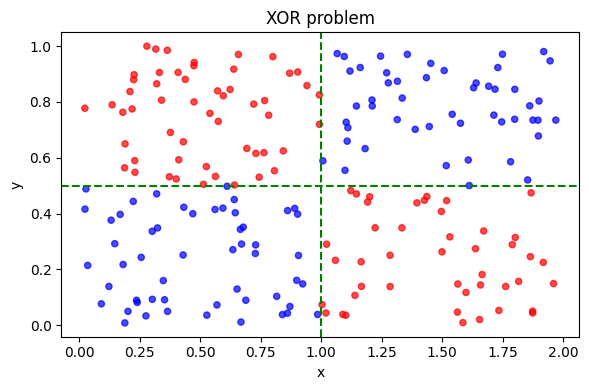

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Generate 200 random coordinates (x,y)
# x in [0,2], y in [0,1]
num_points = 200
x = np.random.uniform(0, 2, num_points)
y = np.random.uniform(0, 1, num_points)

coords = np.column_stack((x, y))
df_coords = pd.DataFrame(coords, columns=["x", "y"])

# 조건에 따라 색상 분류
colors = []
for xi, yi in zip(df_coords["x"], df_coords["y"]):
    if (xi < 1 and yi < 0.5) or (xi > 1 and yi > 0.5):
        colors.append("blue")
    else:
        colors.append("red")

plt.figure(figsize=(6,4))
plt.scatter(df_coords["x"], df_coords["y"], c=colors, alpha=0.7, s=20)
plt.axvline(x=1, color="green", linestyle="--", label="x=1")
plt.axhline(y=0.5, color="green", linestyle="--", label="y=0.5")
#plt.xlim(0,2)
#plt.ylim(0,1)
plt.xlabel("x")
plt.ylabel("y")
plt.title("XOR problem")
#plt.legend()
plt.tight_layout()
plt.show()

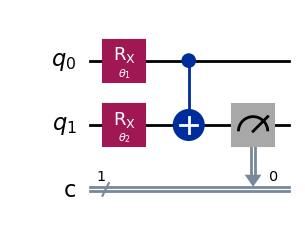

In [34]:
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit

params1 = Parameter("$\\theta_1$")
params2 = Parameter("$\\theta_2$")

qc = QuantumCircuit(2,1)
qc.rx(params1, 0)
qc.rx(params2, 1)
qc.cx(0,1)
qc.measure([1], 0)
qc.draw('mpl')

In [ ]:
# <Z> = cos(Ax) * cos(By)
def Z_expect(x, y, A, B):
    return np.cos(A * x) * np.cos(B * y)

def grads_paramshift(A, B, x, y, s, eps=1e-6):
    """
    그림의 식 (일반화 파라미터-시프트):
      dZ/dA = x * [ Z(A+s,B) - Z(A-s,B) ] / [ 2 * sin(sx) ]
      dZ/dB = y * [ Z(A,B+s) - Z(A,B-s) ] / [ 2 * sin(sy) ]
    안정화: |sin(sx)| 또는 |sin(sy)|가 eps보다 작으면
           해석적 미분 dZ/dA = -x*sin(Ax)*cos(By), dZ/dB = -y*cos(Ax)*sin(By) 사용.
    """
    # 기본 파라미터-시프트
    ZpA = Z_expect(x, y, A + s, B)
    ZmA = Z_expect(x, y, A - s, B)
    ZpB = Z_expect(x, y, A, B + s)
    ZmB = Z_expect(x, y, A, B - s)

    denomA = 2.0 * np.sin(s * x)
    denomB = 2.0 * np.sin(s * y)

    dZ_dA = x * (ZpA - ZmA) / denomA
    dZ_dB = y * (ZpB - ZmB) / denomB

    # 안정화: 분모가 너무 작으면 (또는 x=0 또는 y=0) 해석적 미분으로 대체
    maskA = np.abs(denomA) < eps
    maskB = np.abs(denomB) < eps
    if np.any(maskA):
        dZ_dA[maskA] = -x[maskA] * np.sin(A * x[maskA]) * np.cos(B * y[maskA])
    if np.any(maskB):
        dZ_dB[maskB] = -y[maskB] * np.cos(A * x[maskB]) * np.sin(B * y[maskB])

    # x=0 또는 y=0에서는 정확히 0
    dZ_dA[x == 0.0] = 0.0
    dZ_dB[y == 0.0] = 0.0

    return dZ_dA, dZ_dB

def step_backprop(A, B, x, y, t, s=np.pi/4, lr=0.2):
    """
    한 스텝 수동 역전파.
      - 손실: MSE = mean( (Z - t)^2 )
      - dL/dZ = 2*(Z - t)/N
      - dL/dA = sum_i (dL/dZ_i * dZ_i/dA), dL/dB = sum_i (dL/dZ_i * dZ_i/dB)
    """
    N = x.shape[0]
    Z = Z_expect(x, y, A, B)
    dLdZ = 2.0 * (Z - t) / N

    dZ_dA, dZ_dB = grads_paramshift(A, B, x, y, s)

    dLdA = np.sum(dLdZ * dZ_dA)
    dLdB = np.sum(dLdZ * dZ_dB)

    A_new = A - lr * dLdA
    B_new = B - lr * dLdB

    loss = np.mean((Z - t) ** 2)
    return A_new, B_new, loss, Z

In [ ]:
A, B = 1, 2
theta1 = A * x
theta2 = B * y

for i in range(len(coords)):
    x,y = coords[i]
    expZ_meas, P0, P1, counts = run_pqc(theta1, theta2, shots=2000)
    print(expZ_meas)


0.996
1.0
0.9970000000000001
0.9990000000000001
1.0
1.0
0.9990000000000001
0.9990000000000001
0.998
0.998
0.998
0.9990000000000001
0.9990000000000001
0.998
0.9990000000000001
0.9970000000000001
1.0
0.998
0.9990000000000001
1.0
0.998
0.998
0.9990000000000001
1.0
0.9990000000000001
1.0
0.9990000000000001
1.0
0.9990000000000001
1.0
0.998
0.9990000000000001
0.9990000000000001
1.0
0.9990000000000001
1.0
0.9990000000000001
0.9990000000000001
0.998
0.998
1.0
0.9970000000000001
0.9990000000000001
0.998
1.0
1.0
0.9990000000000001
0.998
0.998
0.9990000000000001
0.998
0.9990000000000001
0.998
0.998
0.9970000000000001
0.998
0.9990000000000001
0.9990000000000001
0.998
0.9990000000000001
0.996
1.0
0.9990000000000001
0.998
1.0
0.998
0.9990000000000001
0.998
0.998
0.9990000000000001
1.0
0.998
1.0
1.0
1.0
1.0
0.998
0.998
0.9990000000000001
1.0
0.9990000000000001
0.996
0.9990000000000001
0.9990000000000001
0.9990000000000001
0.9990000000000001
0.9990000000000001
0.998
0.998
0.9990000000000001
0.99700000

In [36]:
# pip install torch  (필요시)
import torch
from torch import nn
from math import pi

# ---- 1) Z-기대값 모델: <Z> = cos(Ax)*cos(By) ----
#    (원한다면 여기를 실제 회로 시뮬레이터로 바꿔도 됩니다)
def Z_expect(x, y, A, B):
    # x,y: (N,)  / A,B: scalar tensor
    return torch.cos(A * x) * torch.cos(B * y)

# ---- 2) Autograd Function: 파라미터-시프트(일반화 s)로 d/dA, d/dB 구현 ----
class PQCFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, X, A, B, s):
        """
        X: (N, 2) with columns [x, y]
        A, B, s: scalar tensors
        returns: Z (N,) = <Z> for each sample
        """
        x = X[:, 0]
        y = X[:, 1]
        Z = Z_expect(x, y, A, B)
        # 역전파에 필요한 텐서 저장
        ctx.save_for_backward(X, A, B, s)
        return Z

    @staticmethod
    def backward(ctx, grad_output):
        """
        grad_output: (N, ) = dL/dZ
        반환: dL/dX, dL/dA, dL/dB, dL/ds
        (여기서는 dL/dX=0, dL/ds=None 로 설정)
        """
        X, A, B, s = ctx.saved_tensors
        x = X[:, 0]
        y = X[:, 1]

        # --- dZ/dA (일반화된 파라미터-시프트) ---
        # dZ/dA = x * ( Z(A+s, B) - Z(A-s, B) ) / (2 sin(sx))
        ZpA = Z_expect(x, y, A + s, B)
        ZmA = Z_expect(x, y, A - s, B)
        denomA = 2.0 * torch.sin(s * x).clamp(min=1e-12)  # 안정성
        dZ_dA = x * (ZpA - ZmA) / denomA

        # --- dZ/dB ---
        # dZ/dB = y * ( Z(A, B+s) - Z(A, B-s) ) / (2 sin(sy))
        ZpB = Z_expect(x, y, A, B + s)
        ZmB = Z_expect(x, y, A, B - s)
        denomB = 2.0 * torch.sin(s * y).clamp(min=1e-12)
        dZ_dB = y * (ZpB - ZmB) / denomB

        # 체인룰 합계
        dLdA = (grad_output * dZ_dA).sum()        # scalar
        dLdB = (grad_output * dZ_dB).sum()        # scalar
        dLdX = torch.zeros_like(X)                # MATLAB과 동일: 입력 X는 학습 안함
        dLds = None                               # s는 고정

        return dLdX, dLdA, dLdB, dLds

# ---- 3) PQC Layer (PyTorch 모듈) ----
class PQCLayer(nn.Module):
    def __init__(self, A_init=1.0, B_init=1.0, s=pi/4):
        super().__init__()
        # Learnable parameters A, B
        self.A = nn.Parameter(torch.tensor(float(A_init)))
        self.B = nn.Parameter(torch.tensor(float(B_init)))
        # Shift s는 하이퍼파라미터(고정)
        self.register_buffer("s", torch.tensor(float(s)))

    def forward(self, X):
        """
        X: (N, 2), columns = [x, y]
        returns Z: (N,)
        """
        return PQCFunction.apply(X, self.A, self.B, self.s)

# ---- 4) 간단 사용 예시 (XOR 스타일 데이터) ----
if __name__ == "__main__":
    torch.manual_seed(0)

    # 데이터: x∈[0,2], y∈[0,1]
    N = 200
    X = torch.zeros(N, 2)
    X[:, 0] = 2.0 * torch.rand(N)      # x
    X[:, 1] = 1.0 * torch.rand(N)      # y

    # XOR 라벨 (+1 / -1)
    t = torch.where(((X[:,0]<1)&(X[:,1]<0.5)) | ((X[:,0]>1)&(X[:,1]>0.5)),
                    torch.tensor(1.0), torch.tensor(-1.0))

    # 레이어 생성 (요청: 초기 A=B=1)
    pqc = PQCLayer(A_init=1.0, B_init=1.0, s=pi/4)

    # 옵티마이저/손실
    opt = torch.optim.SGD(pqc.parameters(), lr=0.2, momentum=0.9)
    mse = nn.MSELoss()

    for epoch in range(1, 41):
        opt.zero_grad()
        Z = pqc(X)                     # (N,)
        loss = mse(Z, t)
        loss.backward()
        opt.step()

        if epoch % 10 == 0:
            with torch.no_grad():
                pred = torch.sign(Z)
                acc = (pred == torch.sign(t)).float().mean().item()
                print(f"epoch {epoch:2d} | loss={loss.item():.4f} | "
                      f"A={pqc.A.item():.4f} | B={pqc.B.item():.4f} | acc={acc:.3f}")


epoch 10 | loss=0.4064 | A=1.8912 | B=4.0644 | acc=0.875
epoch 20 | loss=0.4776 | A=1.5151 | B=4.2960 | acc=0.860
epoch 30 | loss=0.4231 | A=1.6775 | B=3.0694 | acc=0.930
epoch 40 | loss=0.3923 | A=1.7070 | B=3.6990 | acc=0.910


In [52]:
import numpy as np
from math import pi
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator

# 시뮬레이터 backend 설정
sim = AerSimulator()

def build_xor_pqc(theta1, theta2):
    qc = QuantumCircuit(2, 1)
    qc.rx(theta1, 0)
    qc.rx(theta2, 1)
    qc.cx(0, 1)
    qc.measure(1, 0)
    return qc

def run_pqc(theta1, theta2, shots=4000):
    qc = build_xor_pqc(theta1, theta2)
    job = sim.run(transpile(qc, sim), shots=shots)
    res = job.result()
    c = res.get_counts()
    return (c.get('0', 0) - c.get('1', 0)) / shots  # ⟨Z⟩ 기대값 추정

# 경계 제약용 앵커: 기준선
x_star, y_star = 0.5, 0.5
ys_anchor = np.linspace(0, 1, 9)
xs_anchor = np.linspace(0, 2, 9)

def loss_boundary(A, B, shots=4000, lam=1.0):
    Zx = np.array([run_pqc(A * x_star, B * y, shots) for y in ys_anchor])
    Zy = np.array([run_pqc(A * x, B * y_star, shots) for x in xs_anchor])
    return lam * ((Zx**2).mean() + (Zy**2).mean())

# 해석적 gradient: parameter shift와 수치 미분 비교시 수식 검증 필요
def dZ_dA(x, y, A, B):
    return -x * np.sin(A * x) * np.cos(B * y)

def dZ_dB(x, y, A, B):
    return -y * np.cos(A * x) * np.sin(B * y)

def grad_boundary(A, B, shots=4000, lam=1.0):
    Zx, dA_x, dB_x = [], [], []
    for y in ys_anchor:
        Z = run_pqc(A * x_star, B * y, shots)
        Zx.append(Z); dA_x.append(dZ_dA(x_star, y, A, B)); dB_x.append(dZ_dB(x_star, y, A, B))
    Zy, dA_y, dB_y = [], [], []
    for x in xs_anchor:
        Z = run_pqc(A * x, B * y_star, shots)
        Zy.append(Z); dA_y.append(dZ_dA(x, y_star, A, B)); dB_y.append(dZ_dB(x, y_star, A, B))
    Zx, Zy = np.array(Zx), np.array(Zy)
    dA = lam * ((2 * Zx * np.array(dA_x)).mean() + (2 * Zy * np.array(dA_y)).mean())
    dB = lam * ((2 * Zx * np.array(dB_x)).mean() + (2 * Zy * np.array(dB_y)).mean())
    return dA, dB

# 학습 루프 (pi/4로 스텝 제한, np.clip 적용)
A, B = 1.0, 1.0
s = pi / 4
for epoch in range(1, 101):
    L = loss_boundary(A, B, shots=4000, lam=1.0)
    gA, gB = grad_boundary(A, B, shots=4000, lam=1.0)
    A -= 0.3 * np.clip(gA, -5, 5)
    B -= 0.3 * np.clip(gB, -5, 5)
    print(f"ep{epoch:02d} L={L:.4f} | A={A:.4f} (π≈{pi:.4f}) | B={B:.4f} (π≈{pi:.4f})")


ep01 L=0.8867 | A=1.1192 (π≈3.1416) | B=1.1540 (π≈3.1416)
ep02 L=0.7650 | A=1.1890 (π≈3.1416) | B=1.3045 (π≈3.1416)
ep03 L=0.6759 | A=1.2322 (π≈3.1416) | B=1.4483 (π≈3.1416)
ep04 L=0.6185 | A=1.2648 (π≈3.1416) | B=1.5837 (π≈3.1416)
ep05 L=0.5542 | A=1.2944 (π≈3.1416) | B=1.7048 (π≈3.1416)
ep06 L=0.4906 | A=1.3234 (π≈3.1416) | B=1.8132 (π≈3.1416)
ep07 L=0.4683 | A=1.3474 (π≈3.1416) | B=1.9102 (π≈3.1416)
ep08 L=0.4215 | A=1.3774 (π≈3.1416) | B=1.9974 (π≈3.1416)
ep09 L=0.4003 | A=1.4103 (π≈3.1416) | B=2.0733 (π≈3.1416)
ep10 L=0.3754 | A=1.4479 (π≈3.1416) | B=2.1427 (π≈3.1416)
ep11 L=0.3500 | A=1.4884 (π≈3.1416) | B=2.2063 (π≈3.1416)
ep12 L=0.3360 | A=1.5321 (π≈3.1416) | B=2.2645 (π≈3.1416)
ep13 L=0.3135 | A=1.5794 (π≈3.1416) | B=2.3197 (π≈3.1416)
ep14 L=0.3009 | A=1.6301 (π≈3.1416) | B=2.3665 (π≈3.1416)
ep15 L=0.2839 | A=1.6859 (π≈3.1416) | B=2.4125 (π≈3.1416)
ep16 L=0.2686 | A=1.7463 (π≈3.1416) | B=2.4541 (π≈3.1416)
ep17 L=0.2533 | A=1.8098 (π≈3.1416) | B=2.4943 (π≈3.1416)
ep18 L=0.2330 

KeyboardInterrupt: 

In [54]:
import numpy as np
from math import pi
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator

sim = AerSimulator()

def computeZ(X, A, B, shots=512):
    x1 = X[0, :]
    x2 = X[1, :]
    Z = np.zeros_like(x1, dtype=float)
    for i in range(len(x1)):
        qc = QuantumCircuit(2, 1)
        qc.rx(x1[i]*A, 0)
        qc.rx(x2[i]*B, 1)
        qc.cx(0, 1)
        qc.measure(1, 0)
        job = sim.run(transpile(qc, sim), shots=shots)
        res = job.result()
        c = res.get_counts()
        zval = (c.get('0', 0) - c.get('1', 0)) / shots
        Z[i] = zval
    return Z

def predict(X, A, B):
    return computeZ(X, A, B)

def backward(X, A, B, dLdZ, s=pi/4):
    x1 = X[0, :]
    x2 = X[1, :]
    ZPlus_A = computeZ(X, A+s, B)
    ZMinus_A = computeZ(X, A-s, B)
    dZdA = x1 * (ZPlus_A - ZMinus_A) / (2 * np.sin(x1 * s))
    dLdA = np.sum(dLdZ * dZdA)
    ZPlus_B = computeZ(X, A, B+s)
    ZMinus_B = computeZ(X, A, B-s)
    dZdB = x2 * (ZPlus_B - ZMinus_B) / (2 * np.sin(x2 * s))
    dLdB = np.sum(dLdZ * dZdB)
    dLdX = np.zeros_like(X)
    return dLdX, dLdA, dLdB

# XOR 학습 샘플 생성
np.random.seed(42)
n_sample = 64
X = np.random.rand(2, n_sample)
Y_true = ((X[0, :] > 0.5) != (X[1, :] > 0.5)).astype(float) * 2 - 1

# 파라미터 초기값
A = 1.0
B = 2.0
s = pi / 4

def loss_fn(Z, Y):
    return np.mean((Z - Y) ** 2)

def train(n_epoch=25, eta=0.18):
    global A, B
    for epoch in range(n_epoch):
        Z = predict(X, A, B)
        loss = loss_fn(Z, Y_true)
        dLdZ = 2 * (Z - Y_true) / len(Y_true)
        _, dLdA, dLdB = backward(X, A, B, dLdZ, s=s)
        # Gradient step
        A -= eta * np.clip(dLdA, -4, 4)
        B -= eta * np.clip(dLdB, -4, 4)
        print(f"Epoch {epoch+1:02d}: Loss={loss:.4f}, A={A:.4f}, B={B:.4f}")

train()


Epoch 01: Loss=1.5456, A=1.0074, B=2.0087
Epoch 02: Loss=1.5531, A=1.0148, B=2.0198
Epoch 03: Loss=1.5460, A=1.0234, B=2.0295
Epoch 04: Loss=1.5760, A=1.0312, B=2.0365
Epoch 05: Loss=1.5333, A=1.0380, B=2.0440
Epoch 06: Loss=1.5468, A=1.0437, B=2.0503
Epoch 07: Loss=1.5504, A=1.0498, B=2.0577
Epoch 08: Loss=1.5706, A=1.0559, B=2.0612
Epoch 09: Loss=1.5434, A=1.0612, B=2.0648
Epoch 10: Loss=1.5508, A=1.0648, B=2.0692
Epoch 11: Loss=1.5425, A=1.0691, B=2.0738
Epoch 12: Loss=1.5390, A=1.0759, B=2.0759
Epoch 13: Loss=1.5491, A=1.0807, B=2.0793
Epoch 14: Loss=1.5411, A=1.0840, B=2.0804
Epoch 15: Loss=1.5495, A=1.0879, B=2.0803
Epoch 16: Loss=1.5514, A=1.0960, B=2.0848
Epoch 17: Loss=1.5433, A=1.0999, B=2.0851
Epoch 18: Loss=1.5467, A=1.1035, B=2.0862
Epoch 19: Loss=1.5407, A=1.1056, B=2.0829
Epoch 20: Loss=1.5741, A=1.1088, B=2.0852
Epoch 21: Loss=1.5439, A=1.1144, B=2.0844
Epoch 22: Loss=1.5636, A=1.1178, B=2.0828
Epoch 23: Loss=1.5522, A=1.1229, B=2.0803
Epoch 24: Loss=1.5341, A=1.1268, B

In [55]:
# (1) Grayscale → θ 변환 함수
def grayscale_to_theta(grayscale_value):
    pi = np.pi
    if grayscale_value == 0:
        return 0.0
    elif 1 <= grayscale_value <= 127:
        return (grayscale_value * pi / 255) - (pi / 1020)
    elif 128 <= grayscale_value <= 254:
        return (grayscale_value * pi / 255) + (pi / 1020)
    elif grayscale_value == 255:
        return pi
    else:
        raise ValueError("Grayscale value must be in 0–255")

# (2) θ 값 계산
grayscale_vals = np.arange(0, 256)
theta_vals = np.array([grayscale_to_theta(g) for g in grayscale_vals])

이미지 shape: (1000, 1, 32, 32)
레이블 shape: (1000,)


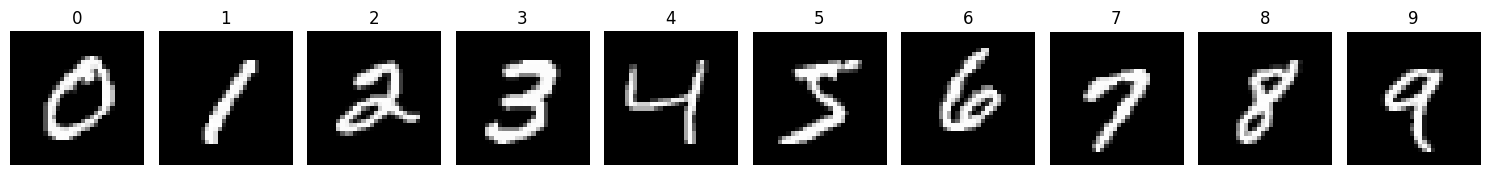

In [66]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
import os

# MNIST 데이터셋 로드
transform = transforms.ToTensor()
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# digit별로 정렬된 이미지와 레이블 저장용 리스트
all_padded_images = []
all_labels = []

# 각 숫자별로 100장씩 수집
for target_digit in range(10):
    count = 0
    for img, label in mnist_dataset:
        if label == target_digit:
            # 28x28 → 32x32 zero padding
            padded_img = F.pad(img, pad=(2, 2, 2, 2), mode='constant', value=0)  # shape: [1, 32, 32]
            all_padded_images.append(padded_img.numpy())  # (1, 32, 32)
            all_labels.append(label)
            count += 1
            if count >= 100:
                break

# numpy 배열로 변환
images_np = np.stack(all_padded_images)  # (1000, 1, 32, 32)
labels_np = np.array(all_labels)         # (1000,)

print("이미지 shape:", images_np.shape)
print("레이블 shape:", labels_np.shape)

# digit별로 하나씩 선택 (0~9)
fig, axes = plt.subplots(1, 10, figsize=(15, 2))

for digit in range(10):
    # digit에 해당하는 index 하나 가져오기
    idx = np.where(labels_np == digit)[0][0]
    
    # (1, 32, 32) → (32, 32)로 변환
    img = images_np[idx, 0]
    
    # subplot에 시각화
    axes[digit].imshow(img, cmap='gray')
    axes[digit].set_title(str(digit))
    axes[digit].axis("off")

plt.tight_layout()
plt.show()

In [67]:
import numpy as np
import math
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

def generate_qc_for_cropped_region(padded_image, crop_start=(2, 2), crop_size=(28, 28)):
    """
    - padded_image: 2D numpy array of shape (32, 32)
    - crop_start: tuple (y_offset, x_offset) indicating top-left of original image
    - crop_size: size of original image region (default: 28x28)
    """
    height, width = padded_image.shape
    y0, x0 = crop_start
    crop_h, crop_w = crop_size

    full_flat = padded_image.flatten()
    thetas = []

    indices_to_encode = []

    for i in range(crop_h):
        for j in range(crop_w):
            global_y = y0 + i
            global_x = x0 + j
            index = global_y * width + global_x  # flat index in padded image
            val = padded_image[global_y, global_x]

            indices_to_encode.append(index)
            thetas.append(round(val / 2, 4))

    # 주소 비트 수 계산
    w_bits = int(np.ceil(math.log2(width)))
    h_bits = int(np.ceil(math.log2(height)))
    num_ind_bits = w_bits + h_bits

    # 회로 구성
    O = QuantumRegister(num_ind_bits, 'q_addr')
    c = QuantumRegister(1, 'q_data')
    cr = ClassicalRegister(num_ind_bits + 1, 'cl')
    qc_image = QuantumCircuit(c, O, cr)

    qc_image.id(c)
    qc_image.h(O)
    qc_image.barrier()

    controls = list(O)

    for index, theta in zip(indices_to_encode, thetas):
        index_bin = format(index, f'0{num_ind_bits}b')

        for k, bit in enumerate(index_bin):
            if bit == '1':
                qc_image.x(O[k])
        qc_image.barrier()

        qc_image.mcry(theta=2 * theta, q_controls=controls, q_target=c[0])
        qc_image.barrier()

        for k, bit in enumerate(index_bin):
            if bit == '1':
                qc_image.x(O[k])

    qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))
    return qc_image

def fill_missing_theta_for_state_0(pixel_theta):
    # (1) 모든 가능한 theta 10bit 문자열
    all_theta = {format(i, '010b') for i in range(1024)}

    # (2) 기존 pixel_theta 중 state가 '0'인 것만 필터링
    state_0_entries = [(state, theta, amount) for state, theta, amount in pixel_theta if state == '0']

    # (3) 존재하는 theta 추출
    existing_theta_0 = {theta for state, theta, amount in state_0_entries}

    # (4) 누락된 theta 확인
    missing_theta_0 = all_theta - existing_theta_0

    # (5) 누락된 항목을 amount=0으로 추가
    filled_entries = list(pixel_theta)  # 원본 복사

    for theta in missing_theta_0:
        filled_entries.append(('0', theta, 0))

    return filled_entries

def sort_by_theta_bin(filled_pixel_theta):
    return sorted(filled_pixel_theta, key=lambda x: int(x[1], 2))

def mean_squared_error(list1, list2):
    if len(list1) != len(list2):
        raise ValueError("Lists must be the same length")
    
    mse = sum((a - b) ** 2 for a, b in zip(list1, list2)) / len(list1)
    return mse

In [68]:
# theta 값을 저장할 리스트
all_theta_images = []

for i in range(len(images_np)):
    img_uint8 = (images_np[i] * 255).astype(np.uint8).squeeze()  # (32, 32)
    
    # np.vectorize로 함수 벡터화
    vectorized_func = np.vectorize(grayscale_to_theta)
    
    theta_img = vectorized_func(img_uint8)  # shape: (32, 32), float
    
    all_theta_images.append(theta_img)

all_theta_images = np.array(all_theta_images)  # shape: (1000, 32, 32)

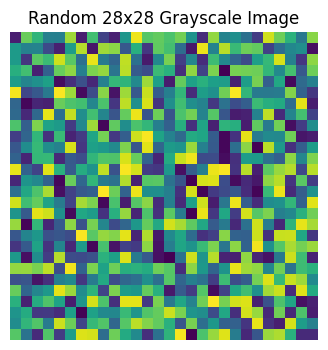

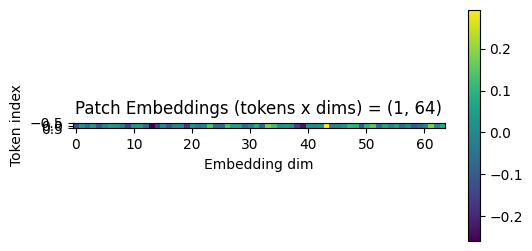

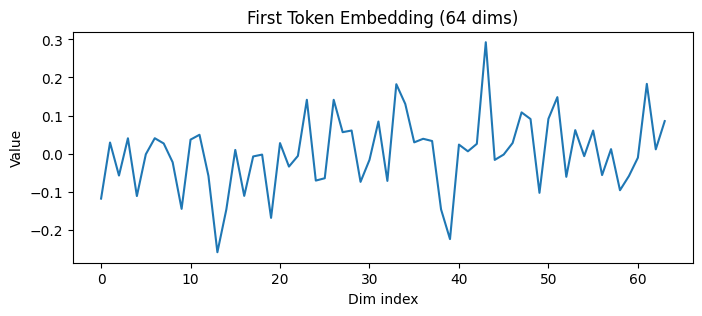

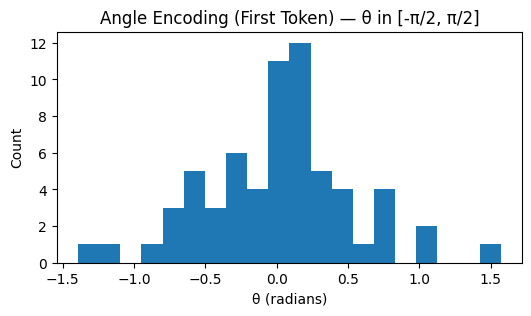

In [69]:
# Re-run after the unexpected state reset.

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
from math import pi


# 1) Make a random 28x28 grayscale image (0..255), then normalize to [0,1]
H, W = 28, 28
rng = np.random.default_rng(42)
img_np = rng.integers(0, 256, size=(H, W), endpoint=True).astype(np.float32)
img_norm = img_np / 255.0
img_tensor = torch.from_numpy(img_norm).unsqueeze(0).unsqueeze(0)  # (B=1, C=1, H, W)

# 2) Patch embedding: Conv2d with kernel_size=stride=16 (non-overlapping 16x16 patches)
patch_size = 16
embed_dim = 64
proj = nn.Conv2d(in_channels=1, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size, bias=True)

torch.manual_seed(0)
nn.init.xavier_uniform_(proj.weight)
nn.init.zeros_(proj.bias)

# 3) Run the patch embedding
emb = proj(img_tensor)                  # (1, 64, 2, 2)
emb = emb.flatten(2).transpose(1, 2)    # (1, 4, 64)
emb_np = emb.detach().cpu().numpy().squeeze(0)  # (4, 64)

# 4) Positional embeddings (zeros for clarity; no change)
Z = emb_np  # final embeddings after pos add (shape: 4 x 64)

# 5) Angle encoding preview for the first token: map to [-pi/2, pi/2]
first_token = Z[0]  # (64,)
max_abs = np.max(np.abs(first_token)) if np.max(np.abs(first_token)) > 0 else 1.0
thetas = (pi / 2) * (first_token / max_abs)  # in [-pi/2, pi/2]

# 6a) Input image
plt.figure(figsize=(4, 4))
plt.title("Random 28x28 Grayscale Image")
plt.imshow(img_np)  # no explicit cmap per instructions
plt.axis("off")
plt.show()

# 6b) Embedding heatmap (tokens x dims)
plt.figure(figsize=(6, 3))
plt.title(f"Patch Embeddings (tokens x dims) = {Z.shape}")
plt.imshow(Z)  # tokens (rows) x dims (cols)
plt.xlabel("Embedding dim")
plt.ylabel("Token index")
plt.colorbar()
plt.show()

# 6c) First token embedding values (line plot)
plt.figure(figsize=(8, 3))
plt.title("First Token Embedding (64 dims)")
plt.plot(first_token)
plt.xlabel("Dim index")
plt.ylabel("Value")
plt.show()

# 6d) Angle encoding preview histogram for the first token
plt.figure(figsize=(6, 3))
plt.title("Angle Encoding (First Token) — θ in [-π/2, π/2]")
plt.hist(thetas, bins=20)
plt.xlabel("θ (radians)")
plt.ylabel("Count")
plt.show()

# 7) Provide tables
df = pd.DataFrame(Z, index=[f"token_{i}" for i in range(Z.shape[0])])


df_theta = pd.DataFrame({"theta_rad": thetas})



In [75]:
emb_np.shape

(1, 64)

In [1]:
import numpy as np
import pandas as pd

# ----------------------------
# 설정
# ----------------------------
CSV_PATH = "64/64 RGB coords_with_bounds.csv"   # 경로/파일명 수정 가능
phi_target = 0.0                                  # 고정 φ (라디안)
tol_phi   = 1e-12                                 # φ 포함 판정 허용오차
tol_theta = 1e-6                                  # θ 인접/연속 판정 허용오차
PI = np.pi
TWOPI = 2*np.pi

# ----------------------------
# 유틸 함수
# ----------------------------
def ang_norm(x):
    """각도를 [0, 2π)로 정규화"""
    return (x % TWOPI + TWOPI) % TWOPI

def angle_in_interval(angle, left, right, tol=1e-12):
    """
    φ ∈ [left, right] 판정. [0,2π)에서 래핑 고려.
    right < left 인 경우 [left, 2π) ∪ [0, right] 로 해석.
    """
    a = ang_norm(angle)
    L = ang_norm(left)
    R = ang_norm(right)
    if L <= R:
        return (a + tol >= L) and (a <= R + tol)
    else:
        # wrap-around
        return (a + tol >= L) or (a <= R + tol)

def merge_intervals(intervals, tol=1e-6):
    """
    θ 구간들의 유니온(합집합) 계산. intervals: [(lo, hi), ...] (정렬되어 있다고 가정하지 않음)
    인접/겹침( hi >= next_lo - tol )이면 병합.
    반환: 병합된 구간 리스트, 그 사이의 갭 리스트
    """
    if not intervals:
        return [], [(0.0, PI)]
    # 0~π 바운드 안으로 클램프
    clipped = [(max(0.0, lo), min(PI, hi)) for (lo, hi) in intervals if hi > 0 and lo < PI]
    if not clipped:
        return [], [(0.0, PI)]
    clipped.sort(key=lambda x: x[0])

    merged = []
    cur_lo, cur_hi = clipped[0]
    for lo, hi in clipped[1:]:
        if lo <= cur_hi + tol:         # 겹치거나 인접
            cur_hi = max(cur_hi, hi)
        else:
            merged.append((cur_lo, cur_hi))
            cur_lo, cur_hi = lo, hi
    merged.append((cur_lo, cur_hi))

    # 갭 계산
    gaps = []
    # 시작부 갭
    if merged[0][0] > tol:
        gaps.append((0.0, merged[0][0]))
    # 내부 갭들
    for (a_lo, a_hi), (b_lo, b_hi) in zip(merged, merged[1:]):
        if b_lo - a_hi > tol:
            gaps.append((a_hi, b_lo))
    # 끝부분 갭
    if PI - merged[-1][1] > tol:
        gaps.append((merged[-1][1], PI))

    return merged, gaps

# ----------------------------
# 데이터 로드
# ----------------------------
df = pd.read_csv(CSV_PATH)

# 필요한 컬럼 존재 여부 점검 (이름이 다르면 여기서 바꿔주세요)
required_cols = ['r','g','b','theta_lower','theta_upper','phi_left','phi_right']
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"CSV에 다음 컬럼이 필요합니다: {missing}")

# ----------------------------
# φ 타깃에 해당하는 행 선별
# ----------------------------
mask_phi = df.apply(
    lambda row: angle_in_interval(phi_target, row['phi_left'], row['phi_right'], tol=tol_phi),
    axis=1
)
sel = df.loc[mask_phi, ['r','g','b','theta_lower','theta_upper','phi_left','phi_right']].copy()
sel = sel.sort_values('theta_lower', kind='mergesort').reset_index(drop=True)

# ----------------------------
# 인접 θ 구간 간격(gap) 계산 (정렬 순서 기준, 단순 연속성 점검)
# ----------------------------
sel['next_theta_lower'] = sel['theta_lower'].shift(-1)
sel['gap_to_next'] = sel['next_theta_lower'] - sel['theta_upper']
sel['relation_to_next'] = np.where(
    sel['gap_to_next'].isna(), 'last',
    np.where(sel['gap_to_next'] > tol_theta, 'gap',
    np.where(sel['gap_to_next'] < -tol_theta, 'overlap', 'contiguous'))
)

# ----------------------------
# 유니온 커버리지 기반 요약 (θ∈[0,π] 대비)
# ----------------------------
intervals = list(zip(sel['theta_lower'].to_numpy(), sel['theta_upper'].to_numpy()))
merged, gaps = merge_intervals(intervals, tol=tol_theta)
covered = sum(max(0.0, hi - lo) for lo, hi in merged)
coverage_ratio = covered / PI

# ----------------------------
# 결과 출력(요약)
# ----------------------------
print(f"[고정 φ = {phi_target:.6f} rad] 선택된 RGB 개수: {len(sel)}")
print(f"θ 범위 유니온 커버리지: {covered:.9f} (/{PI:.9f})  ->  {coverage_ratio*100:.6f}%")
print(f"병합된 커버 구간(개수 {len(merged)}):")
for i,(lo,hi) in enumerate(merged[:20]):  # 너무 길면 앞부분만
    print(f"  #{i:02d}: [{lo:.9f}, {hi:.9f}]  (len={hi-lo:.9f})")
if len(merged) > 20:
    print("  ...")

if gaps:
    print(f"\n⚠️ 발견된 θ 갭(개수 {len(gaps)}):")
    for i,(lo,hi) in enumerate(gaps[:20]):
        print(f"  gap#{i:02d}: ({hi-lo:.9f}) in [{lo:.9f}, {hi:.9f}]")
    if len(gaps) > 20:
        print("  ...")
else:
    print("\n✅ θ 상에 빈 공간(갭) 없음 (tol_theta 기준)")

# ----------------------------
# 필요 시: 연속/갭/겹침 테이블 미리보기
# ----------------------------
print("\n인접 구간 관계(상위 30행 미리보기):")
print(sel[['r','g','b','theta_lower','theta_upper','next_theta_lower','gap_to_next','relation_to_next']].head(30).to_string(index=False))


[고정 φ = 0.000000 rad] 선택된 RGB 개수: 13731
θ 범위 유니온 커버리지: 2.871362142 (/3.141592654)  ->  91.398296%
병합된 커버 구간(개수 121):
  #00: [0.000000000, 0.043633231]  (len=0.043633231)
  #01: [0.056099869, 0.068566506]  (len=0.012466638)
  #02: [0.081033144, 0.099733100]  (len=0.018699956)
  #03: [0.108044192, 0.124666375]  (len=0.016622183)
  #04: [0.132977467, 0.152716310]  (len=0.019738843)
  #05: [0.158949628, 0.177649585]  (len=0.018699956)
  #06: [0.183882903, 0.204452855]  (len=0.020569952)
  #07: [0.209439510, 0.229386130]  (len=0.019946620)
  #08: [0.234372785, 0.255566069]  (len=0.021193284)
  #09: [0.259721615, 0.280499344]  (len=0.020777729)
  #10: [0.284654890, 0.306323093]  (len=0.021668203)
  #11: [0.309884990, 0.331256368]  (len=0.021371379)
  #12: [0.334818265, 0.356857499]  (len=0.022039234)
  #13: [0.359974158, 0.381790774]  (len=0.021816616)
  #14: [0.384907433, 0.407243492]  (len=0.022336059)
  #15: [0.410013856, 0.432176767]  (len=0.022162911)
  #16: [0.434947131, 0.457525597]  